# Generation of samples from a random/conditional gaussian copula

This code allows for creating random and conditional samples from a gaussian copula. 

A vector of d random variables is denoted as $\mathbf{X} \in \mathbb{R}^{d}$. 

The joint probability distribution is defined by providing:

* Each variable marginal probability distribution (in the form of a parametric pdf structure).

* An internal correlation structure defined by a correlation matrix $\mathbf{ \rho } \in \mathbb{R}^{dxd}$.

Two functions are available:

* RadomGaussianCopula_Sample: Allows for generating random samples of size N which respects each marginal distribution and reproduces the correlation structure.

* ConditionalGaussianCopula_Sample: Generates samples from the joint probability distribution of the variables providing that the values of m variables are already known. Thus, forming the conditional distribution of the other n = d - m variables.

An example is also described in which samples are drawn from a 3 dimentional space. With two gaussian and a lognormal distributions.

The unconditional and the conditional distribution of 2 parameters are shown when knowing the value of the third variable.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as st
import statsmodels as sm

import matplotlib.gridspec as gridspec
import seaborn as sns; sns.set()


plt.style.use('seaborn-white')
%matplotlib inline

In [20]:
def ConditionalGaussianCopula_Sample(distributions, parameters, CorrMatrix, nsamples, conditionalValue):
    """
    Gaussian copula random vector sample for a d dimentional joint probability distribution. 
    It computes the conditional probability distribution of the copula given a set of conditionalvalues from n variables.
    
    :distributions: list(), d parametric probability distributions from scipy.stats.   example: distributions = [st.norm, st.lognorm, st.norm]
    
    :parameters: list(), a list of the parameters associated to each distribution.  example: parameters = [(100, 30),(0.5, 1, 100),(30, 10)] as par[-2] = loc, par[-1] = scale and par[:-2] = *args
    
    :CorrMatrix: array(d,d), CorrelationMatrix for the copula.
    
    :conditionalValue: list(), [[ind, value],[ind, value],...] Index and value of the n parameters which are conditioned.
    
    :nsamples: integer, number of required samples from the conditional copula (of the d-n dimensions).
    
    """
    
    
    # Step 1 - Compute conditional scheme from the conditioned parameter.
    
    Standard_Value_condition = []
    
    for value in conditionalValue:
        
        # Fx(X=X1)
        Uniform_Value_condition = distributions[value[0]].cdf( value[1], loc = parameters[value[0]][-2], 
                                                                          scale = parameters[value[0]][-1], 
                                                                          *parameters[value[0]][:-2])
        # Fn(0,1)^-1(Fx(X=X1))
        Standard_Value_condition.append(st.norm.ppf(Uniform_Value_condition, 
                                                        scale = CorrMatrix[value[0],value[0]]**0.5))


    Standard_Value_condition = np.array(Standard_Value_condition)
    
    
    # Split 2D Cov array in two sets fixed and conditioned variables
    Z11 = np.zeros([len(list(zip(*conditionalValue))[0]), len(list(zip(*conditionalValue))[0])])

    for n, i in enumerate(list(zip(*conditionalValue))[0]):
        for m, j in enumerate(list(zip(*conditionalValue))[0]):
            Z11[n,m] = CorrMatrix[i,j]

    oposite_ind = range(len(CorrMatrix))
    oposite_ind = [i for i in oposite_ind if i not in list(zip(*conditionalValue))[0]]

    Z22 = np.zeros([len(oposite_ind), len(oposite_ind)])

    for n, i in enumerate(oposite_ind):
        for m, j in enumerate(oposite_ind):
            Z22[n,m] = CorrMatrix[i,j]

    Z21 = np.zeros([len(oposite_ind), len(list(zip(*conditionalValue))[0])])

    for n, i in enumerate(oposite_ind):
        for m, j in enumerate(list(zip(*conditionalValue))[0]):
            Z21[n,m] = CorrMatrix[i,j]

    Z12 = Z21.T
    
    Cond_mean = Z21.dot(np.linalg.inv(Z11).dot(Standard_Value_condition))
    Cond_Cov = Z22 - np.dot(Z21, np.dot(np.linalg.inv(Z11), Z12))

    # Step 2 - Draw MVN(conditionalmean, ConditionalCov)
    MVR = np.random.multivariate_normal(mean = Cond_mean, cov = Cond_Cov, size = nsamples)  
    
    Marginals = np.zeros(np.shape(MVR))

    distributions_P = [distributions[i] for i in range(len(distributions)) if i not in zip(*conditionalValue)[0]]
    parameters_P = [parameters[i] for i in range(len(parameters)) if i not in zip(*conditionalValue)[0]]
    
    for i, column in enumerate(MVR.T):
        
        scaleGauss = 1
        params = parameters_P[i]
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Step 3 - To each variable apply F(0,1) and Apply inverse cdf marginal cdf_i**(-1)

        Marginals[:,i] = distributions_P[i].ppf(st.norm.cdf(column, scale = scaleGauss), loc=loc, scale=scale, *arg)

    return Marginals

def RadomGaussianCopula_Sample(distributions, parameters, CorrMatrix, nsamples):
    import numpy as np
    import scipy.stats as st
    """
    Gaussian copula random vector sample for a n dimentional joint probability distribution.
    nsamples 
    distributions: n distribution names from scipy.stats 
    params: fitted parameter vector
    CovMatrix: covariance matrix from the measured data
    """
    
    # Step 1 - Draw MVN(0, Cov)
    MVR = np.random.multivariate_normal(mean = np.zeros(len(distributions)), cov = CorrMatrix, size = nsamples)
    Marginals = np.zeros(np.shape(MVR))
    for i, column in enumerate(MVR.T):
        scaleGauss = CorrMatrix[i,i]**0.5
        params = parameters[i]
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]
        
        # Step 2/3 - To each variable apply F(0,cov[i,i] - std) and Apply marginal cdf**(-1)
        
        Marginals[:,i] = distributions[i].ppf(st.norm.cdf(column, scale = scaleGauss), loc=loc, scale=scale, *arg)
        
    return Marginals

In [40]:
### Auxiliary plotting functions
class SeabornFig2Grid():
    """
    Plot several Seaborn joinplot together  #https://stackoverflow.com/a/46906599/4124317
    """
    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

### Copula Samples

Three variables are distributed according to the following marginal probabilidy distributions

$$ X_a \sim N(\mu = 100, \sigma = 30) $$
$$ X_b \sim Lognormal(s = 0.5, loc = 1, scale = 100) $$
$$ X_c \sim N(\mu = 30, \sigma = 10) $$


Also, there is an underlying correlation structure between the three variables. This is described by the Spearman's 
correlation matrix:

$$ \rho = 
  \begin{bmatrix}
    1 & 0.2 & 0.5 \\
    0.2 & 1 & 0.9 \\
    0.5 & 0.9 & 1 \\
  \end{bmatrix} $$


In [39]:
# parametric marginals and correlation matrix:

Distributions = [st.norm, st.lognorm, st.norm]

Parameters = [(100, 30),
              (0.5, 1, 100),
             (30, 10)]

CorrMatrix = np.array([[1, 0.2, 0.5], 
                       [0.2, 1, .9],
                       [0.5, .9, 1]])

#### 1-  Unconditional copula

First, 5000 samples are drawn using a Gaussian copula. The correlation matrix of the generated sample closely matches the initially provided.

Also the joint plot is provided representing the joint distribution of 2-by-2 couples.

In [38]:
Marginals =  RadomGaussianCopula_Sample(Distributions, Parameters, CorrMatrix, nsamples = 5000)
MarginalCop = pd.DataFrame(Marginals, columns= ['X_a', 'X_b', 'X_c'])

In [15]:
MarginalCop.corr('spearman')

,X_a,X_b,X_c
X_a,1.000000,0.178667,0.472256
X_b,0.178667,1.000000,0.887558
X_c,0.472256,0.887558,1.000000


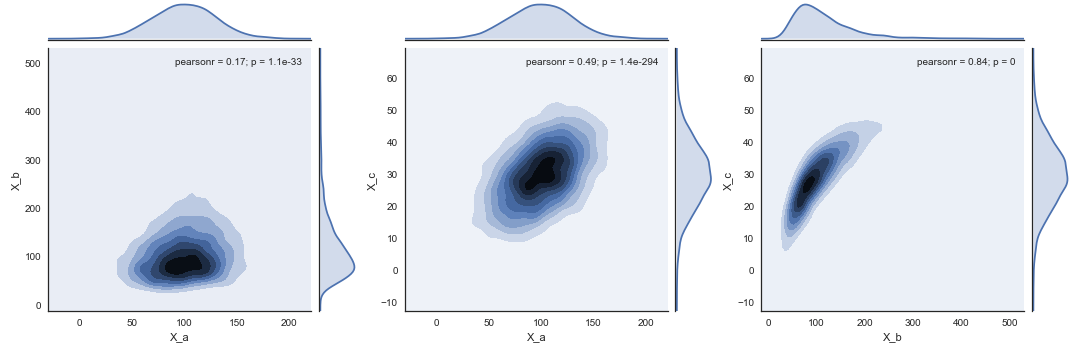

In [17]:
g0 = sns.jointplot(x=MarginalCop['X_a'], y= MarginalCop['X_b'], kind='kde')
g1 = sns.jointplot(x=MarginalCop['X_a'], y= MarginalCop['X_c'], kind='kde')
g2 = sns.jointplot(x=MarginalCop['X_b'], y= MarginalCop['X_c'], kind='kde')

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1, 3)
mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])
mg2 = SeabornFig2Grid(g2, fig, gs[2])

gs.tight_layout(fig)
plt.show()

#### 2-  Conditional copula sample

The value of $X_c$ is known to be 10. 

Then, 5000 samples are drawn from the joint probability distribution of the other 2 free variables ($X_a$ and $X_b$) conditioned to $X_c = 10$.


In [23]:
MarginalsConditional = ConditionalGaussianCopula_Sample(Distributions, Parameters, CorrMatrix
                                                       , nsamples = 5000, conditionalValue=[[2,10]])

MarginalsConditional = pd.DataFrame(MarginalsConditional, columns= ['X_a','X_b'])
MarginalsConditional['X_c'] = 10

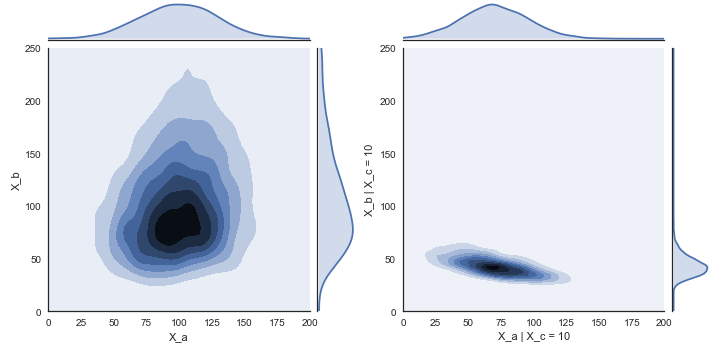

UnConditional Spearman Correlation X_a, X_b = 0.178667310571
Conditional Spearman Correlation X_a, X_b = -0.651622556881


In [37]:
g0 = sns.jointplot(x=MarginalCop['X_a'], y= MarginalCop['X_b'], kind='kde', xlim = (0,200), ylim = (0,250), stat_func=None)

MarginalsConditional2plot = MarginalsConditional.copy()
MarginalsConditional2plot.columns = ['X_a | X_c = 10', 'X_b | X_c = 10', 'X_c']

MarginalsConditional2plot.loc[1000] = [200,250,10] # Articifial points in order to set the limits in the join plot (not used in the normal computation)
MarginalsConditional2plot.loc[1001] = [0,0,10]

g1 = sns.jointplot(x=MarginalsConditional2plot['X_a | X_c = 10'], y= MarginalsConditional2plot['X_b | X_c = 10'], kind='kde', xlim = (0,200), ylim = (0,250),stat_func=None)

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1, 2)

mg0 = SeabornFig2Grid(g0, fig, gs[0])
mg1 = SeabornFig2Grid(g1, fig, gs[1])

gs.tight_layout(fig)
plt.show()

print r'UnConditional Spearman Correlation X_a, X_b = {}'.format(MarginalCop[['X_a','X_b']].corr('spearman')['X_b']['X_a'])
print r"Conditional Spearman Correlation X_a, X_b = {}".format(MarginalsConditional[['X_a','X_b']].corr('spearman')['X_b']['X_a'])

##### Notes: 


1- The function ConditionalGaussianCopula_Sample can be used to constrain an arbitrary number of dimensions from a given joint probability distribution defined by a gaussian copula.

2- It is curious to see that parting from a completely positive correlation matrix, by conditioning one variable, the conditioned output can result in negatively correlated samples. This is explained by the nature of the  multivariate gaussian distribution, in which the conditioned covariance matrix is computed as: 
$$ \hat{\Sigma} = \Sigma_{12} - \Sigma_{12} \cdot \Sigma_{22}^{-1} \cdot \Sigma_{21} $$

And each component refers to the splitting of the correlation matrix in:

$$ \rho = 
  \begin{bmatrix}
    \Sigma_{11} & \Sigma_{12}  \\
    \Sigma_{21} & \Sigma_{22}  
  \end{bmatrix}
$$

for which, $ X_{22} $ are the components of the m conditioned dimensions and $ X_{11} $ are the $n = d-m$ free variables from the initial space $\mathbf{X} \in \mathbb{R}^{d}$. It is noted that the conditioned covariance matrix in the multivariate gaussian scheme doesn't depend in the conditioned value and only on the initial correlation matrix form, and that for some positive structures it can lead to conditioned negative correlations. This phenomena is inherited by the gaussian copula scheme.